# ANOVA

In [1]:
!pip install pingouin
import pandas as pd
import scipy.stats
import numpy as np
import pingouin as pg
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from termcolor import colored
import operator

from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot

## Part1: Data preparation

In [2]:
# Read the data from the file
# Data from https://www.kaggle.com/datasets/piumiu/used-cars-database-50000-data-points
import requests
excel_url = 'https://docs.google.com/spreadsheets/d/1iMQNC9lKf2HcEv_qsVZFtH7JYyNlkF65ert2qc8ruZU/export?format=xlsx'
response = requests.get(excel_url)
response.raise_for_status()  # Ensure the request was successful
with open('sheet.xlsx', 'wb') as file:
    file.write(response.content)
df = pd.read_excel('sheet.xlsx')

In [3]:
# Check the first few lines to see the column names and type of content
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,odometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-26 17:47:46,Peugeot_807_160_NAVTECH_ON_BOARD,privat,Angebot,"$5,000",control,bus,2004,manuell,158,andere,"150,000km",3,lpg,peugeot,nein,2016-03-26,0,79588,2016-04-06 06:45:54
1,2016-04-04 13:38:56,BMW_740i_4_4_Liter_HAMANN_UMBAU_Mega_Optik,privat,Angebot,"$8,500",control,limousine,1997,automatik,286,7er,"150,000km",6,benzin,bmw,nein,2016-04-04,0,71034,2016-04-06 14:45:08
2,2016-03-26 18:57:24,Volkswagen_Golf_1.6_United,privat,Angebot,"$8,990",test,limousine,2009,manuell,102,golf,"70,000km",7,benzin,volkswagen,nein,2016-03-26,0,35394,2016-04-06 20:15:37
3,2016-03-12 16:58:10,Smart_smart_fortwo_coupe_softouch/F1/Klima/Pan...,privat,Angebot,"$4,350",control,kleinwagen,2007,automatik,71,fortwo,"70,000km",6,benzin,smart,nein,2016-03-12,0,33729,2016-03-15 03:16:28
4,2016-04-01 14:38:50,Ford_Focus_1_6_Benzin_TÜV_neu_ist_sehr_gepfleg...,privat,Angebot,"$1,350",test,kombi,2003,manuell,0,focus,"150,000km",7,benzin,ford,nein,2016-04-01,0,39218,2016-04-01 14:38:50


In [4]:
# Size of the dataframe
df.shape

(50000, 20)

In [5]:
# Remove rows with empty values
df = df.replace(r'^\s*$', float('NaN'), regex = True)
df.dropna(inplace = True)
df.shape

(35047, 20)

In [6]:
# Let us check the types of the different columns
df.dtypes

dateCrawled            datetime64[ns]
name                           object
seller                         object
offerType                      object
price                          object
abtest                         object
vehicleType                    object
yearOfRegistration              int64
gearbox                        object
powerPS                         int64
model                          object
odometer                       object
monthOfRegistration             int64
fuelType                       object
brand                          object
notRepairedDamage              object
dateCreated            datetime64[ns]
nrOfPictures                    int64
postalCode                      int64
lastSeen               datetime64[ns]
dtype: object

In [7]:
# Let us adapt the dataframe (remove IDs, and make sure that columns have the right type)
del df['dateCrawled']
del df['name']
del df['model']
del df['dateCreated']
del df['nrOfPictures']
del df['postalCode']
del df['lastSeen']
del df['seller']
del df['offerType']

df['abtest'] = df['abtest'].astype('category')
df['vehicleType'] = df['vehicleType'].astype('category')
df['gearbox'] = df['gearbox'].astype('category')
df['fuelType'] = df['fuelType'].astype('category')
df['brand'] = df['brand'].astype('category')
df['notRepairedDamage'] = df['notRepairedDamage'].astype('category')
df['yearOfRegistration'] = df['yearOfRegistration'].astype(float)
df['powerPS'] = df['powerPS'].astype(float)
df['monthOfRegistration'] = df['monthOfRegistration'].astype('category')

In [8]:
for index, row in df.iterrows():
    df.loc[index,'price']=float(row['price'].replace('$','').replace(',',''))
    df.loc[index,'odometer']=float(row['odometer'].replace('km','').replace(',',''))
df['price'] = df['price'].astype(float)
df['odometer'] = df['odometer'].astype(float)

In [9]:
# # Let us check the types of the final dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35047 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   price                35047 non-null  float64 
 1   abtest               35047 non-null  category
 2   vehicleType          35047 non-null  category
 3   yearOfRegistration   35047 non-null  float64 
 4   gearbox              35047 non-null  category
 5   powerPS              35047 non-null  float64 
 6   odometer             35047 non-null  float64 
 7   monthOfRegistration  35047 non-null  category
 8   fuelType             35047 non-null  category
 9   brand                35047 non-null  category
 10  notRepairedDamage    35047 non-null  category
dtypes: category(7), float64(4)
memory usage: 2.6 MB


## Part 2: Data exploration

In [10]:
# Lets see the summary of the numerical columns
df.describe()

,price,yearOfRegistration,powerPS,odometer
count,3.504700e+04,35047.000000,35047.000000,35047.000000
mean,7.442565e+03,2003.351014,127.414843,124172.825063
std,8.949139e+04,6.457460,182.485798,39725.783587
min,0.000000e+00,1931.000000,0.000000,5000.000000
25%,1.500000e+03,1999.000000,80.000000,100000.000000
50%,3.800000e+03,2004.000000,116.000000,150000.000000
75%,8.600000e+03,2008.000000,150.000000,150000.000000
max,1.234568e+07,2018.000000,17700.000000,150000.000000


array([[<Axes: title={'center': 'price'}>]], dtype=object)

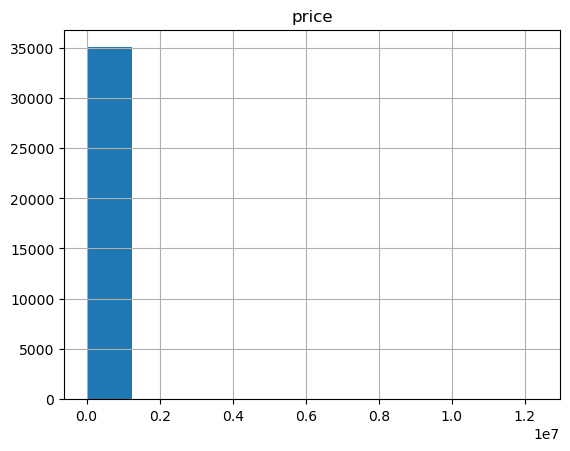

In [11]:
# Histogram of prices
df.hist(column="price")

In [12]:
# Remove outliers
df=df[(np.abs(stats.zscore(df[['price','yearOfRegistration','powerPS','odometer']])) < 3).all(axis=1)]
df=df[(np.abs(stats.zscore(df[['price','yearOfRegistration','powerPS','odometer']])) < 3).all(axis=1)]
df.shape

(33446, 11)

In [13]:
df.describe()

,price,yearOfRegistration,powerPS,odometer
count,33446.000000,33446.000000,33446.000000,33446.000000
mean,5856.737667,2003.595318,119.985918,126402.559349
std,6100.562971,5.503539,56.142059,37245.977604
min,0.000000,1987.000000,0.000000,10000.000000
25%,1500.000000,2000.000000,77.000000,100000.000000
50%,3650.000000,2004.000000,116.000000,150000.000000
75%,8000.000000,2008.000000,150.000000,150000.000000
max,33500.000000,2018.000000,321.000000,150000.000000


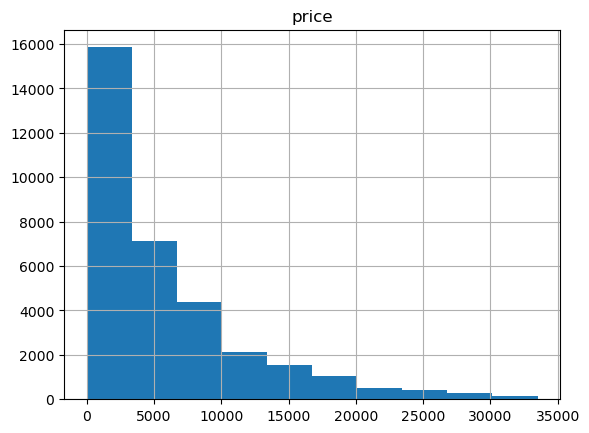

In [14]:
# Histogram of prices
df.hist(column="price");

### We filter those YEARS and BRANDS of interest (important *)

Final size of the dataframe df:  (33446, 11)


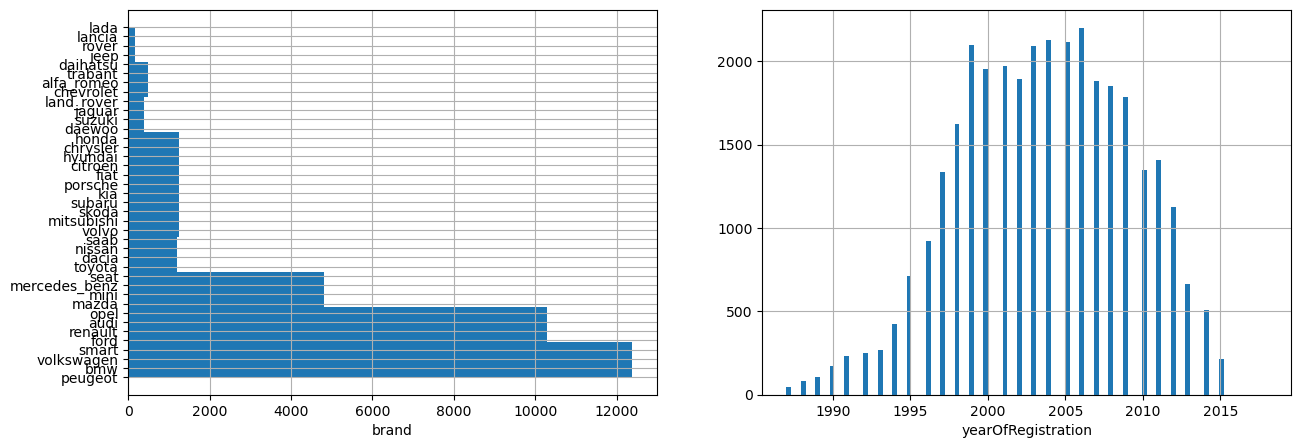

In [15]:
#  Filter data to set the final problem
first_year = 1987
last_year = 2018
brands = ['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen', 'dacia',
          'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai', 'jaguar', 'jeep', 'kia',
          'lada', 'lancia', 'land_rover', 'mazda', 'mercedes_benz', 'mini', 'mitsubishi',
          'nissan', 'opel', 'peugeot', 'porsche', 'renault', 'rover', 'saab', 'seat',
          'skoda', 'smart', 'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo']

rows_sel = df.brand.isin(brands) & ((df.yearOfRegistration >= first_year) &  (df.yearOfRegistration <= last_year))
df = df.loc[rows_sel]

print('Final size of the dataframe df: ', df.shape)
fig = plt.figure(1, figsize=(15, 5)) 
plt.subplot(1,2,1)
df['brand'].hist(orientation = 'horizontal')
plt.xlabel('brand')
plt.subplot(1,2,2)
df['yearOfRegistration'].hist(bins=100)
plt.xlabel('yearOfRegistration')
plt.show()

In [16]:
# Let us explore the correlation matrix
corrMatrix = df.corr(numeric_only=True)
print (corrMatrix)

                       price  yearOfRegistration   powerPS  odometer
price               1.000000            0.669840  0.529052 -0.496859
yearOfRegistration  0.669840            1.000000  0.231506 -0.524444
powerPS             0.529052            0.231506  1.000000  0.000468
odometer           -0.496859           -0.524444  0.000468  1.000000


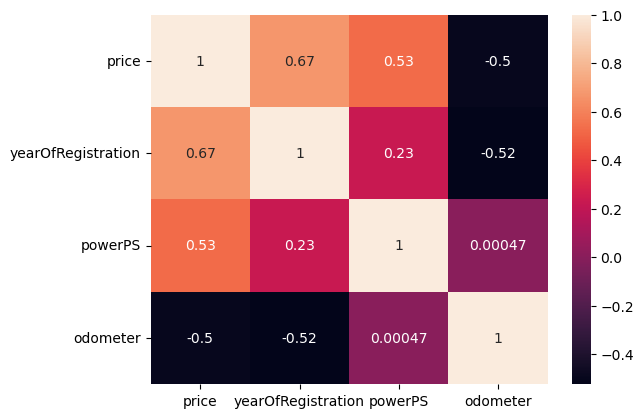

In [17]:
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [18]:

def explore(df, yname, xname):
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    sns.boxplot(x=xname, y=yname, data=df, ax=ax)
    # sns.swarmplot(x=xname, y=yname, data=df, color='black', alpha = 0.5, ax=ax);
    
    print('Checking normality with Shapiro-Wilk')
    print(pg.normality(data=df, dv=yname, group=xname))
    
    print(' ')
    print('Checking homocedasticity')
    print(pg.homoscedasticity(data=df, dv=yname, group=xname, method='levene'))
    
    print(' ')
    print('Checking dependence of y on x (1-way ANOVA)')
    aov=pg.anova(data=df, dv=yname, between=xname, detailed=True)
    print(aov)
    pvalue = aov['p-unc'][0]
    if pvalue<0.05:
        color='green'
    else:
        color='red'
    print(colored('p-value=%f'%pvalue,color))
    return aov['F'][0]

Checking normality with Shapiro-Wilk
                W  pval  normal
abtest                         
control  0.808545   0.0   False
test     0.803829   0.0   False
 
Checking homocedasticity
               W      pval  equal_var
levene  1.044421  0.306803       True
 
Checking dependence of y on x (1-way ANOVA)
   Source            SS     DF            MS         F     p-unc       np2
0  abtest  6.389206e+07      1  6.389206e+07  1.716787  0.190116  0.000051
1  Within  1.244654e+12  33444  3.721607e+07       NaN       NaN       NaN
p-value=0.190116


C:\Users\plosa\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\plosa\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


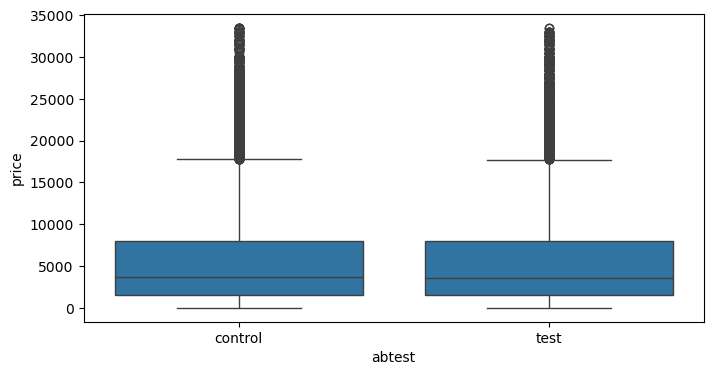

In [19]:
F={}
F['abtest']=explore(df,"price", "abtest")

Checking normality with Shapiro-Wilk
                    W          pval  normal
vehicleType                                
bus          0.832419  0.000000e+00   False
limousine    0.805473  0.000000e+00   False
kleinwagen   0.763467  0.000000e+00   False
kombi        0.834308  0.000000e+00   False
coupe        0.865565  2.147071e-35   False
suv          0.948627  3.296509e-22   False
cabrio       0.882264  4.596918e-38   False
andere       0.763876  3.153360e-17   False
 
Checking homocedasticity
                 W  pval  equal_var
levene  329.512795   0.0      False
 
Checking dependence of y on x (1-way ANOVA)
        Source            SS     DF            MS          F  p-unc       np2
0  vehicleType  1.439363e+11      7  2.056233e+10  624.61353    0.0  0.115638
1       Within  1.100782e+12  33438  3.292009e+07        NaN    NaN       NaN
p-value=0.000000


C:\Users\plosa\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\plosa\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\plosa\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


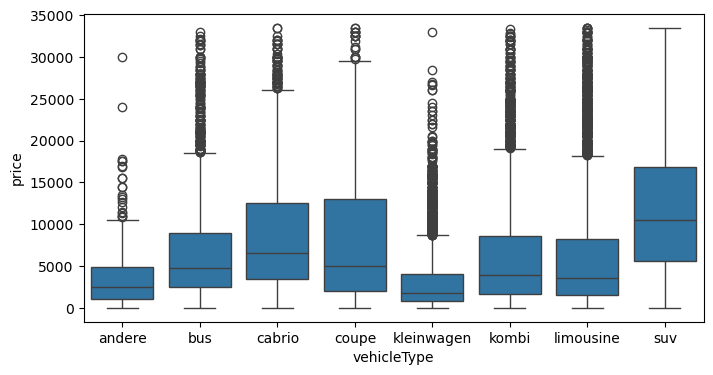

In [20]:
F['vehicleType']=explore(df,"price","vehicleType")

Checking normality with Shapiro-Wilk
                  W  pval  normal
gearbox                          
manuell    0.798058   0.0   False
automatik  0.896241   0.0   False
 
Checking homocedasticity
                 W  pval  equal_var
levene  2101.05146   0.0      False
 
Checking dependence of y on x (1-way ANOVA)
    Source            SS     DF            MS            F  p-unc       np2
0  gearbox  1.189281e+11      1  1.189281e+11  3533.012705    0.0  0.095546
1   Within  1.125790e+12  33444  3.366195e+07          NaN    NaN       NaN
p-value=0.000000


C:\Users\plosa\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\plosa\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


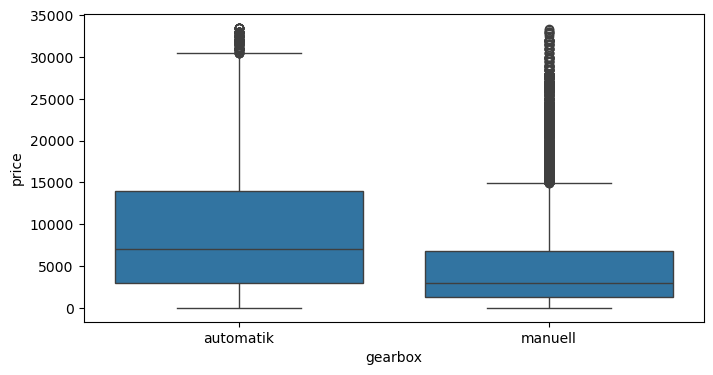

In [21]:
F['gearbox']=explore(df,"price", "gearbox")

Checking normality with Shapiro-Wilk
                            W          pval  normal
monthOfRegistration                                
3                    0.798462  0.000000e+00   False
6                    0.802028  0.000000e+00   False
7                    0.812486  0.000000e+00   False
12                   0.808877  0.000000e+00   False
9                    0.812781  0.000000e+00   False
11                   0.820119  0.000000e+00   False
5                    0.797687  0.000000e+00   False
2                    0.801255  0.000000e+00   False
1                    0.808429  0.000000e+00   False
10                   0.821266  0.000000e+00   False
8                    0.814450  2.802597e-45   False
4                    0.819364  0.000000e+00   False
0                    0.685998  1.524391e-38   False
 
Checking homocedasticity
                W          pval  equal_var
levene  21.923283  4.100090e-49      False
 
Checking dependence of y on x (1-way ANOVA)
                Source  

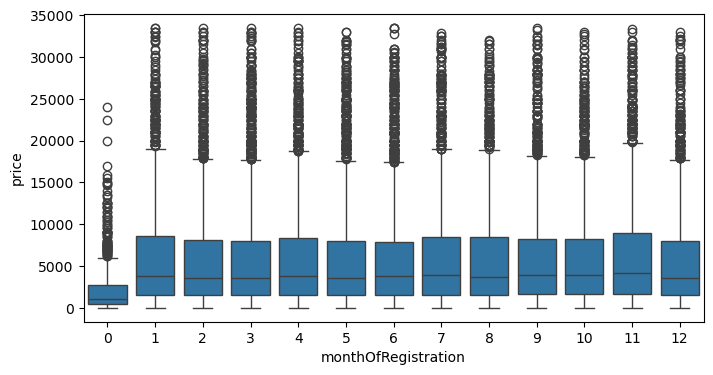

In [22]:
F['monthOfRegistration']=explore(df,"price", "monthOfRegistration")

Checking normality with Shapiro-Wilk
                 W          pval  normal
fuelType                                
lpg       0.842376  1.185111e-21   False
benzin    0.749714  0.000000e+00   False
diesel    0.884661  0.000000e+00   False
cng       0.879287  4.418638e-05   False
hybrid    0.876177  6.967182e-03   False
elektro   0.894028  2.963408e-01    True
andere    0.779645  2.561810e-02   False
 
Checking homocedasticity
                 W           pval  equal_var
levene  208.463839  4.103976e-262      False
 
Checking dependence of y on x (1-way ANOVA)
     Source            SS     DF            MS          F  p-unc      np2
0  fuelType  1.172653e+11      6  1.954422e+10  579.65974    0.0  0.09421
1    Within  1.127453e+12  33439  3.371670e+07        NaN    NaN      NaN
p-value=0.000000


C:\Users\plosa\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\plosa\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


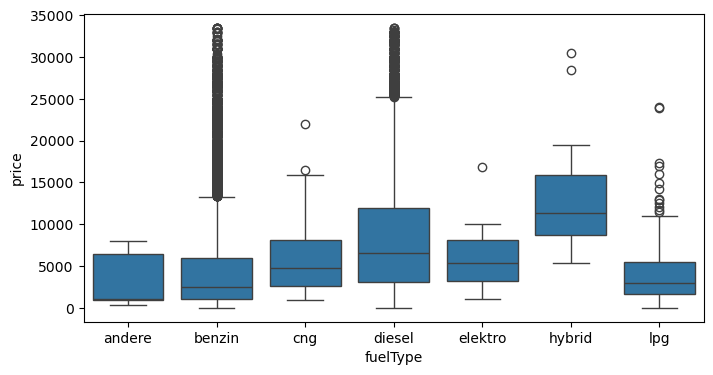

In [23]:
F['fuelType']=explore(df,"price", "fuelType")

Checking normality with Shapiro-Wilk
                      W          pval  normal
brand                                        
peugeot        0.799599  5.279860e-34   False
bmw            0.883482  0.000000e+00   False
volkswagen     0.823567  0.000000e+00   False
smart          0.915136  6.753489e-15   False
ford           0.741738  0.000000e+00   False
renault        0.701691  0.000000e+00   False
audi           0.898168  1.449153e-40   False
opel           0.749328  0.000000e+00   False
mazda          0.754489  5.763843e-27   False
mini           0.945997  3.179030e-10   False
mercedes_benz  0.852299  0.000000e+00   False
seat           0.813538  8.747454e-27   False
toyota         0.819321  7.816229e-23   False
dacia          0.935934  7.358654e-05   False
nissan         0.802774  2.861849e-25   False
saab           0.709665  1.109568e-09   False
volvo          0.800660  3.933947e-20   False
mitsubishi     0.713401  2.023251e-21   False
skoda          0.871231  2.436493e-22   Fal

C:\Users\plosa\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


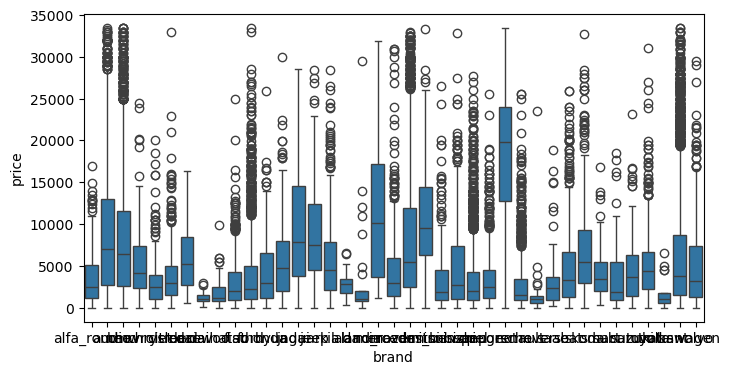

In [24]:
F['brand']=explore(df,"price", "brand")

Checking normality with Shapiro-Wilk
                          W  pval  normal
notRepairedDamage                        
nein               0.821405   0.0   False
ja                 0.619010   0.0   False
 
Checking homocedasticity
                  W           pval  equal_var
levene  1015.473057  1.509777e-219      False
 
Checking dependence of y on x (1-way ANOVA)
              Source            SS     DF            MS           F  p-unc  \
0  notRepairedDamage  5.473680e+10      1  5.473680e+10  1538.35804    0.0   
1             Within  1.189981e+12  33444  3.558131e+07         NaN    NaN   

        np2  
0  0.043975  
1       NaN  
p-value=0.000000


C:\Users\plosa\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


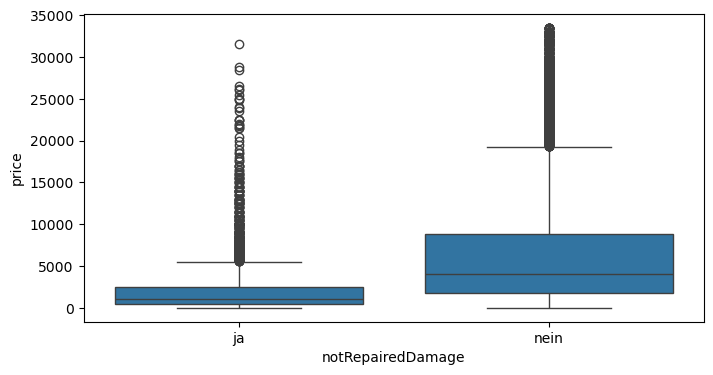

In [25]:
F['notRepairedDamage']=explore(df,"price","notRepairedDamage")

In [26]:
# Sort F by value
for k, Fk in sorted(F.items(), key=operator.itemgetter(1) ,reverse=True):
     print('%s: F=%f'%(k,Fk))

gearbox: F=3533.012705
notRepairedDamage: F=1538.358040
vehicleType: F=624.613530
fuelType: F=579.659740
brand: F=133.017810
monthOfRegistration: F=31.316460
abtest: F=1.716787


## 2-way ANOVA

We want to determine if there is a relationship between any of the discrete variables and the price. ANOVA is a technique of the form y=f(X) where y is continuous and X is discrete.

We have seen above that, if any, there is a relationship with gearbox, notRepairedDamage, vehicleType, and FuelType. We will not use brand and monthOfRegistration, as they explain much less variability than the rest.

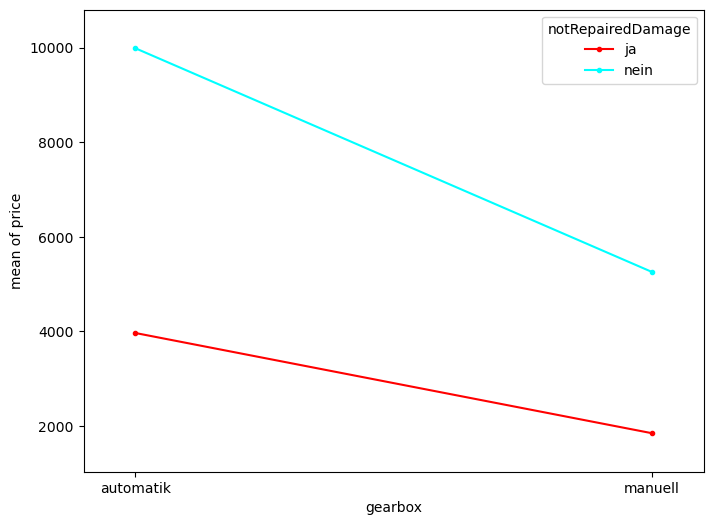

In [27]:
# Let us explore interactions
fig, ax = plt.subplots(figsize=(8, 6))
fig = interaction_plot(
    x        = df.gearbox.astype('object'),
    trace    = df.notRepairedDamage.astype('object'),
    response = df.price,
    ax       = ax,
)

So there is an interaction between gearbox and notRepairedDamage.

In [28]:
# Two-way ANOVA
# ==============================================================================
pg.anova(
    data     = df,
    dv       = 'price',
    between  = ['gearbox', 'notRepairedDamage'],
    detailed = True
).round(4)

,Source,SS,DF,MS,F,p-unc,np2
0,gearbox,1.140753e+11,1.0,1.140753e+11,3556.9618,0.0,0.0961
1,notRepairedDamage,4.988400e+10,1.0,4.988400e+10,1555.4244,0.0,0.0444
2,gearbox * notRepairedDamage,3.388093e+09,1.0,3.388093e+09,105.6435,0.0,0.0031
3,Residual,1.072518e+12,33442.0,3.207099e+07,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,np2
0,gearbox,7.562790e+10,1.0,7.562790e+10,2479.0486,0.0,0.0690
1,vehicleType,1.006361e+11,7.0,1.437659e+10,471.2582,0.0,0.0898
2,gearbox * vehicleType,5.310833e+09,7.0,7.586904e+08,24.8695,0.0,0.0052
3,Residual,1.019843e+12,33430.0,3.050682e+07,NaN,NaN,NaN


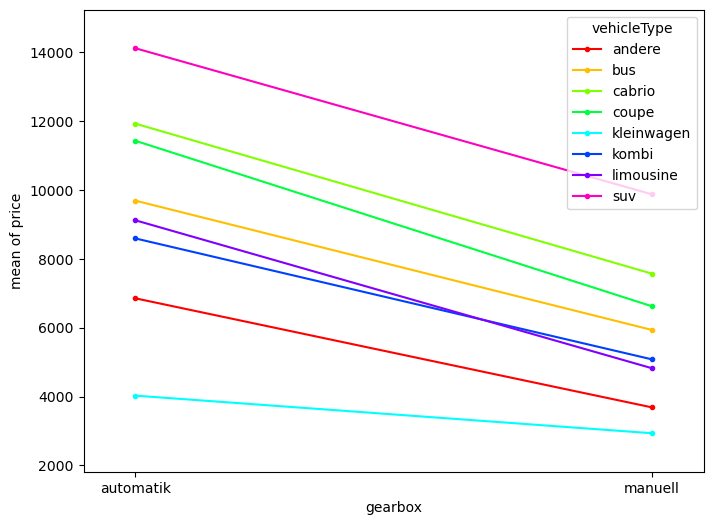

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
fig = interaction_plot(
    x        = df.gearbox.astype('object'),
    trace    = df.vehicleType.astype('object'),
    response = df.price,
    ax       = ax,
)
pg.anova(
    data     = df,
    dv       = 'price',
    between  = ['gearbox', 'vehicleType'],
    detailed = True
).round(4)

There are significant interactions, but they are very weak.

,Source,SS,DF,MS,F,p-unc,np2
0,gearbox,8.462475e+10,1.0,8.462475e+10,2722.6282,0.0,0.0753
1,fuelType,8.296197e+10,6.0,1.382699e+10,444.8553,0.0,0.0739
2,gearbox * fuelType,3.694475e+09,6.0,6.157458e+08,19.8104,0.0,0.0035
3,Residual,1.039134e+12,33432.0,3.108201e+07,NaN,NaN,NaN


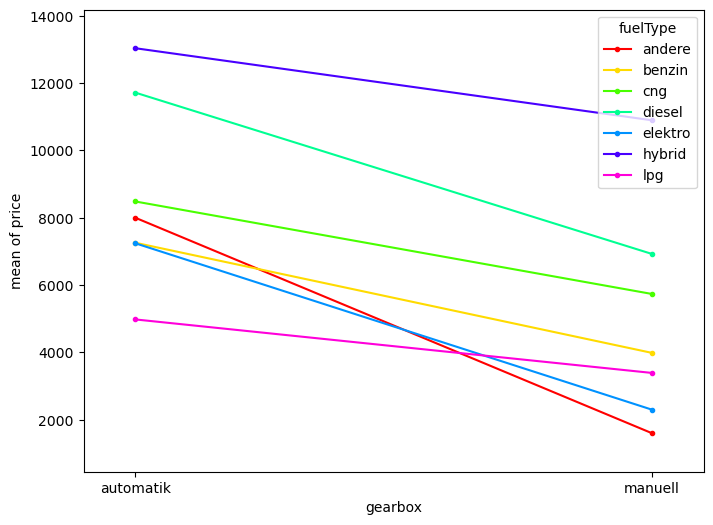

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
fig = interaction_plot(
    x        = df.gearbox.astype('object'),
    trace    = df.fuelType.astype('object'),
    response = df.price,
    ax       = ax,
)
pg.anova(
    data     = df,
    dv       = 'price',
    between  = ['gearbox', 'fuelType'],
    detailed = True
).round(4)

There are significant interactions, but they are very weak. In general, we will not estimate interactions

## Multi-way ANOVA

In [31]:
formula = "price ~ gearbox + notRepairedDamage + vehicleType + fuelType"
lm = ols(formula, df).fit()
print(lm.summary())
print(colored("The R2 of this model is %f"%lm.rsquared_adj,"green"))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     787.5
Date:                Sun, 04 Aug 2024   Prob (F-statistic):               0.00
Time:                        22:09:20   Log-Likelihood:            -3.3392e+05
No. Observations:               33446   AIC:                         6.679e+05
Df Residuals:                   33430   BIC:                         6.680e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

## Pure regression

In [32]:
df['cYear']=df['yearOfRegistration']-df['yearOfRegistration'].mean()
df['cPower']=df['powerPS']-df['powerPS'].mean()
df['cOdometer']=df['odometer']-df['odometer'].mean()
formula = "price ~ cYear + cPower + cOdometer"
lm = ols(formula, df).fit()
print(lm.summary())
print(colored("The R2 of this model is %f"%lm.rsquared_adj,"green"))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                 2.065e+04
Date:                Sun, 04 Aug 2024   Prob (F-statistic):               0.00
Time:                        22:09:20   Log-Likelihood:            -3.2145e+05
No. Observations:               33446   AIC:                         6.429e+05
Df Residuals:                   33442   BIC:                         6.429e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5856.7377     19.753    296.498      0.0

The average price of a car is 5856.7, for every year the car loses 473 euros. More powerful cars are more expensive (46 euros/Power horse). And cars with more kilometers are cheaper, -0.04 euros/km.

Let us try now to add quadratic terms.

In [33]:
formula = "price ~ cYear + cPower + cOdometer + cYear*cPower + cYear*cOdometer + cPower*cOdometer"
lm = ols(formula, df).fit()
print(lm.summary())
print(colored("The R2 of this model is %f"%lm.rsquared_adj,"green"))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                 1.505e+04
Date:                Sun, 04 Aug 2024   Prob (F-statistic):               0.00
Time:                        22:09:20   Log-Likelihood:            -3.1710e+05
No. Observations:               33446   AIC:                         6.342e+05
Df Residuals:                   33439   BIC:                         6.343e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         5247.7618     20.769  

## Mixed models

In [34]:
formula += "+ gearbox + notRepairedDamage + vehicleType + fuelType"
lm = ols(formula, df).fit()
print(lm.summary())
print(colored("The R2 of this model is %f"%lm.rsquared_adj,"green"))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     5167.
Date:                Sun, 04 Aug 2024   Prob (F-statistic):               0.00
Time:                        22:09:20   Log-Likelihood:            -3.1479e+05
No. Observations:               33446   AIC:                         6.296e+05
Df Residuals:                   33424   BIC:                         6.298e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             